# Combine features

At this stage we are going to combine the behavioural, eeg and mri data.

We are then gonna train a linear model with the purpose to both reconstruct the original data based on a latent space but also based on the predictions for the multi-label problem

For these experiments, we have omitted multiple same diagnoses for the same patient. That means that multiple diagnoses of Neurological diseases for instance will be eliminated.

In [0]:
%reload_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 5, 10
rcParams['font.size'] = 12

plt.style.use('ggplot')

In [2]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


In [3]:
# upload autoencoder python files

from google.colab import files

uploaded = files.upload()

Saving combined_features.ipynb to combined_features.ipynb
Saving autoencode_seq.py to autoencode_seq.py
Saving autoencoder_sequence_predict.py to autoencoder_sequence_predict.py
Saving autoencode_predict.py to autoencode_predict.py
Saving disorder_generator.py to disorder_generator.py
Saving autoencoder.py to autoencoder.py


## Combine features

### Load behavioural data and preprocess dataset

In [4]:
base_dir = '/gdrive/My Drive/Colab Notebooks/DSLab/data'

behaviour_data = pd.read_csv(os.path.join(base_dir, 'HBNFinalSummaries.csv'), low_memory=False)

initial_size = behaviour_data.shape[0]
behaviour_data = behaviour_data[behaviour_data['NoDX'].isin(['Yes', 'No'])]
new_size = behaviour_data.shape[0]
print('Removing', initial_size - new_size,
      'patients as their evaluation was incomplete.')

keep_most_common_diseases = 5
healthy_diagnosis = 'No Diagnosis Given'

# these disorders should also include the no diagnosis given option
keep_most_common_diseases += 1

category_columns = ['DX_' + str(i).zfill(2) + '_Cat' for i in range(1, 11)]

# count for each disorder number of occurences
disorder_counts = {}
for val in behaviour_data[category_columns].values.reshape(-1):
    if not pd.isnull(val):
        if val in disorder_counts:
            disorder_counts[val] += 1
        else:
            disorder_counts[val] = 1

# sort in descending order
disorder_counts = sorted(disorder_counts.items(), key=lambda kv: -kv[1])

most_common_disorders = [x[0]
                         for x in disorder_counts[:keep_most_common_diseases]]

# find users that have no diagnosis within these top diseases
# filtering should cahnge anything as this should also happen at a later stage
mask = None
for col in category_columns:
    mask_col = behaviour_data[col].isin(most_common_disorders)
    if mask is None:
        mask = mask_col
    else:
        mask = mask | mask_col

initial_size = behaviour_data.shape[0]
behaviour_data = behaviour_data[mask]
behaviour_data = behaviour_data.reset_index(drop=True)
new_size = behaviour_data.shape[0]
print('Removing', initial_size - new_size,
      'patients as their diagnoses were very uncommon.')

Removing 282 patients as their evaluation was incomplete.
Removing 37 patients as their diagnoses were very uncommon.


In [0]:
no_diagnosis_given = 'No Diagnosis Given'

if no_diagnosis_given in most_common_disorders:
    no_diag_index = most_common_disorders.index(no_diagnosis_given)
    most_common_disorders = most_common_disorders[:no_diag_index] + \
        most_common_disorders[no_diag_index + 1:]

In [0]:
diagnoses_to_ids = {disorder: i for i, disorder in enumerate(most_common_disorders)}

In [0]:
order_of_disorders = []
for k in range(behaviour_data.shape[0]):
    i = 0
    disorder = behaviour_data.iloc[k][category_columns[i]]
    disorders_patient = []
    while disorder != no_diagnosis_given and not pd.isnull(disorder):
        if disorder in diagnoses_to_ids:
            if diagnoses_to_ids[disorder] not in disorders_patient:
                disorders_patient.append(diagnoses_to_ids[disorder])
        i += 1
        if i == len(category_columns):
            break
        disorder = behaviour_data.iloc[k][category_columns[i]]

    order_of_disorders.append(disorders_patient)

In [0]:
max_len_order = np.max([len(x) for x in order_of_disorders])

# pad with a new token denoting the pad token
pad_token = len(most_common_disorders)
bod_token = len(most_common_disorders) + 1
eod_token = len(most_common_disorders) + 2

order_of_disorders = [[bod_token] + x + [eod_token] + [pad_token] * (max_len_order - len(x)) for x in order_of_disorders]

order_of_disorders = np.array(order_of_disorders)

Many diseases are also present many times. What should we do with them? I have only considered the first presence of a disorder for a patient! 

In [0]:
classes = np.zeros((len(most_common_disorders),
                    behaviour_data.shape[0]), dtype=np.int32)


df_disorders = behaviour_data[category_columns]

for i, disorder in enumerate(most_common_disorders):
    mask = df_disorders.select_dtypes(include=[object]). \
        applymap(lambda x: disorder in x if pd.notnull(x) else False)

    disorder_df = df_disorders[mask.any(axis=1)]

    np.add.at(classes[i], disorder_df.index.values, 1)

In [0]:
behaviour_data_columns = behaviour_data.columns.values.astype(np.str)

columns_to_drop = behaviour_data_columns[
    np.flatnonzero(np.core.defchararray.find(behaviour_data_columns, 'DX') != -1)]

behaviour_data = behaviour_data.drop(columns=columns_to_drop)

In [0]:
for disorder, classification in zip(most_common_disorders, classes):
    behaviour_data[disorder] = classification

behaviour_data['order_diagnoses'] = list(order_of_disorders)

In [12]:
behaviour_data.shape

(1777, 312)

In [0]:
combined_df = behaviour_data.set_index('EID')

### Load mri and add to dataset

In [0]:
fa_per_tract = pd.read_csv('DataScience2019_MRI/MRI/DTI/FAPerTract.csv', low_memory=False)

# Remove "/" from the end some IDs 
fa_per_tract['ID'] = fa_per_tract['ID'].apply(lambda x: x[:-1] if "/" in x else x)

# join with behavioural data
combined_df = combined_df.join(fa_per_tract.set_index('ID'), how='inner')

In [0]:
# base_dir = 'DataScience2019_MRI/MRI/structuralMRI'

# column ScanSite already exists in the behavioural data
cort_thick_l = pd.read_csv(os.path.join(base_dir,
    'CorticalThicknessLHROI.csv'), low_memory=False).drop(columns=['ScanSite'])
cort_thick_r = pd.read_csv(os.path.join(base_dir,
    'CorticalThicknessRHROI.csv'), low_memory=False).drop(columns=['eTIV', 'ScanSite'])
cort_vol_l = pd.read_csv(os.path.join(base_dir,
    'CorticalVolumeLHROI.csv'), low_memory=False).drop(columns=['eTIV', 'ScanSite'])
cort_vol_r = pd.read_csv(os.path.join(base_dir,
    'CorticalVolumeRHROI.csv'), low_memory=False).drop(columns=['eTIV', 'ScanSite'])
sub_cort_vol_l = pd.read_csv(os.path.join(base_dir,
    'SubCorticalVolumeLHROI.csv'), low_memory=False).drop(columns=['eTIV', 'ScanSite'])
sub_cort_vol_r = pd.read_csv(os.path.join(base_dir,
    'SubCorticalVolumeRHROI.csv'), low_memory=False).drop(columns=['eTIV', 'ScanSite'])
glob_thick = pd.read_csv(os.path.join(base_dir,
    'GlobalCorticalThickness.csv'), low_memory=False).drop(columns=['ScanSite'])

# Join tables 
struct_mri = pd.merge(cort_thick_l, cort_thick_r, on='ID', how='inner')
struct_mri = pd.merge(struct_mri, cort_vol_l, on='ID', how='inner')
struct_mri = pd.merge(struct_mri, cort_vol_r, on='ID', how='inner')
struct_mri = pd.merge(struct_mri, sub_cort_vol_l, on='ID', how='inner')
struct_mri = pd.merge(struct_mri, sub_cort_vol_r, on='ID', how='inner')
struct_mri = pd.merge(struct_mri, glob_thick, on='ID', how='inner')

In [15]:
combined_df = combined_df.join(struct_mri.set_index('ID'), how='inner')
combined_df.shape

(1053, 685)

### Load EEG  and add to dataset

In [0]:
base_dir = 'DataScience2019_MRI/EEG'

eeg_mic = pd.read_csv(os.path.join(base_dir, "RestingEEG_Microstates.csv"))
eeg_psd = pd.read_csv(os.path.join(base_dir, "RestingEEG_PSD_Average.csv"))
eeg_spectro = pd.read_csv(os.path.join(base_dir, "RestingEEG_Spectro_Average.csv"))

In [0]:
combined_df = combined_df.join(eeg_mic.set_index('id'), how='inner')
combined_df = combined_df.join(eeg_psd.set_index('id'), how='inner')
combined_df = combined_df.join(eeg_spectro.set_index('id'), how='inner')

combined_df.shape

(950, 735)


### Some final preprocessing

In [0]:
# fdx and mdx may contain 'No Diagnosis'
# drop them for now but they may be important
# they correspond to father's and mother's primary diagnosis
columns_to_drop = ['Anonymized.ID', 'mdx', 'fdx', 'fcodxm_1', 'fcodxm_2', 'fcodxm_3', 'mcodxm_1',
                   'mcodxm_2', 'mcodxm_3', 'mcodxmdt', 'TOWRE_Total_Desc', 'Picture_Vocab_Raw',
                   'sib1dx', 'sib1codxm_1', 'sib1codxm_2', 'sib1codxm_3',
                   'sib2dx', 'sib2codxm_1', 'sib2codxm_2', 'sib2codxm_3',
                   'sib3dx', 'sib3codxm_1', 'sib3codxm_2', 'sib3codxm_3',
                   'sib4dx', 'sib4codxm_1', 'sib4codxm_2', 'sib4codxm_3',
                   'sib5dx', 'sib5codxm_1', 'sib5codxm_2', 'sib5codxm_3']

combined_df = combined_df.drop(columns=columns_to_drop)

In [17]:
combined_df.shape

(1053, 653)

## Train

For this time we have only considered the behavioural data and the structural mri as these datasets have the most ids in common.

In [0]:
assert combined_df.shape == (1053, 653) # if you only include the behavioural and the structural

classes = combined_df[most_common_disorders].values
orders = np.stack(combined_df['order_diagnoses'].values)

combined_df = combined_df.drop(columns=most_common_disorders + ['order_diagnoses'])

In [53]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

def mean_imputer(x, y):
    return np.where(np.isnan(x), np.ma.array(x, mask=np.isnan(x)).mean(axis=0), x),\
            np.where(np.isnan(y), np.ma.array(x, mask=np.isnan(x)).mean(axis=0), y)  

# we are goint to remove some behavioral data based on their null values
drop_missing_threshold = 0.5

train_index, test_index = train_test_split(np.array(list(range(combined_df.shape[0]))), test_size=0.2, random_state=17)

train, test = combined_df.iloc[train_index], combined_df.iloc[test_index]
train_classes, test_classses = classes[train_index], classes[test_index]
train_orders, test_orders = orders[train_index], orders[test_index]

columns_mask = pd.isnull(train).sum() / train.shape[0] >= drop_missing_threshold

print('Droping this many columns:', np.sum(columns_mask))

dropped_columns = train.columns[columns_mask]

train = train.drop(columns=dropped_columns)
test = test.drop(columns=dropped_columns)

train_mask = pd.isnull(train).values.astype(np.float32)
test_mask = pd.isnull(test).values.astype(np.float32)

# deal with numpy because of some weird SettingWithCopyWarning I cannot figure out
# impute based on the mean values
train, test = mean_imputer(train.values, test.values)

scaler = MinMaxScaler()
train = scaler.fit_transform(train)
test = scaler.transform(test)

Droping this many columns: 130


## Autoencoder + classification

In [20]:
print(train.shape)
print(test.shape)

(842, 517)
(211, 517)


In [21]:
import tensorflow as tf
from autoencode_predict import AutoencodePredict, multi_label_accuracy, f1_per_class

alpha=0.2          # parameter showing the significance of the prediction loss
activation=tf.nn.relu
layers=[50, 25]
prediction_layers=[125, 50]
dropout=0.1
regularization=1e-5
masking=0.1

model = AutoencodePredict(train.shape[1], len(most_common_disorders), alpha=alpha, activation=activation, layers=layers,
                          prediction_layers=prediction_layers, dropout=dropout, regularization=regularization, 
                          masking=masking)

In [0]:
learning_rate = 3e-3
# pos_weights = [1, 1, 1, 1, 1]
# set larger weight for instances of disorders that are very infrequent

def smoothing_fun(a, beta=1):
    return [min(i, 1) for i in a] + beta * np.log([max(i - 1, 1) for i in a])

pos_weights = smoothing_fun(1 / (np.sum(train_classes, axis=0) / train_classes.shape[0]))
class_weights = [1, 1, 1, 1, 1]

decay_steps = train.shape[0] // 64 * 20
model.fit(train, train_mask, train_classes, test_data=test, test_data_mask=test_mask, test_data_labels=test_classes,
          n_epochs=1000, print_every_epochs=200, pos_weights=pos_weights, class_weights=class_weights,
          decay_steps=decay_steps)

Using only behavioural:

At epoch 2000 rec_loss:   0.0943 reg_loss:   0.1133 pred_loss:  11.0274 train_acc: 0.8756 test_acc 0.8522<br>
train f1_scores: 0.736 0.757 0.784 0.826 0.673 test f1_scores: 0.719 0.719 0.746 0.716 0.523<br>

Total recall: 0.7884615384615384<br>
Total precision: 0.6923076923076923<br>
<br>

Behavioural + structural mri:

At epoch 2000 rec_loss:   0.0151 reg_loss:   0.0533 pred_loss:   7.0952 train_acc: 0.8646 test_acc 0.8313
train f1_scores: 0.713 0.725 0.795 0.816 0.739 test f1_scores: 0.694 0.708 0.705 0.731 0.545 

Total recall: 0.7758007117437722<br>
Total precision: 0.6546546546546547<br>
<br>

In [23]:
preds = model.predict(test)

INFO:tensorflow:Restoring parameters from ./autoencoder_predict/model-800


In [0]:
# total recall
def precision_recall(true, predictions):
    indices = np.where(true == 1)
    total = len(indices[0])
    found = 0
    for i, j in zip(indices[0], indices[1]):
        found += predictions[i][j]

    # total precision, total recall
    return found / np.sum(predictions), found / total

In [25]:
print(multi_label_accuracy(test_classes, preds))
print(precision_recall(test_classes, preds))
print(f1_per_class(test_classes, preds))

0.842654028436019
(0.6837060702875399, 0.7615658362989324)
[0.7480296154764747, 0.7090563779691443, 0.7796194541573952, 0.7163978494623656, 0.5204545454545454]


In [0]:
# alpha=0.2          # parameter showing the significance of the prediction loss
# activation=tf.nn.relu
# layers=[50, 25]
# prediction_layers=[125, 50]
# dropout=0.1
# regularization=1e-5
# masking=0.1

# decay_steps = train.shape[0] // 64 * 20
# n_epochs = 1000

# 0.8511848341232228
# (0.7758007117437722, 0.6987179487179487)
# [0.7162648153360227, 0.7715955834596233, 0.7363068304244775, 0.7249947445869245, 0.48284313725490197]

In [26]:
print(np.sum(test_classes, axis=0))
print(np.sum(preds, axis=0))

[154  58  28  29  12]
[162  75  33  33  10]


### Lets see how our method holds againt a simple classical classifier

In [0]:
def classify(data, labels, test_data, classifier):
    final_predictions = np.zeros((test_data.shape[0], labels.shape[1]), dtype=np.int16)
    for i in range(labels.shape[1]):
        classifier.fit(data, labels[:, i])
        final_predictions[:, i] = classifier.predict(test_data)

    return final_predictions

In [0]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# clf = SVC(class_weight='balanced')
clf = RandomForestClassifier(class_weight='balanced', n_estimators=100, max_depth=4)

predictions_classical = classify(train, train_classes, test, clf)

In [29]:
print(multi_label_accuracy(test_classes, predictions_classical))
print(precision_recall(test_classes, predictions_classical))
print(f1_per_class(test_classes, predictions_classical))

0.8369668246445497
(0.7011070110701108, 0.6761565836298933)
[0.7352996129721073, 0.6918120113411805, 0.7195081422399469, 0.7237255586592178, 0.48536585365853663]


SVC(class_weight='balanced')<br>
0.7146919431279621<br>
(0.6443148688046647, 0.7864768683274022)<br>
[0.691970802919708, 0.7308673469387755, 0.6461490683229814, 0.6764567114885587, 0.4330666348220683]<br>
<br>
clf = RandomForestClassifier(class_weight='balanced', n_estimators=100, max_depth=4)<br>
0.8407582938388626<br>
(0.6443148688046647, 0.7864768683274022)<br>
[0.7259147001515479, 0.7204493087557604, 0.6844466600199401, 0.7401477832512315, 0.48536585365853663]

### Clustering patients based on the latent space (I have dones these plots for the train dataset but the final result should probably be on the test dataset)

In [31]:
latent_space = model.get_latent_space(train)

INFO:tensorflow:Restoring parameters from ./autoencoder_predict/model-800


#### Existence of a particular disorder

In [0]:
import umap

reducer = umap.UMAP()
embedding = reducer.fit_transform(latent_space)

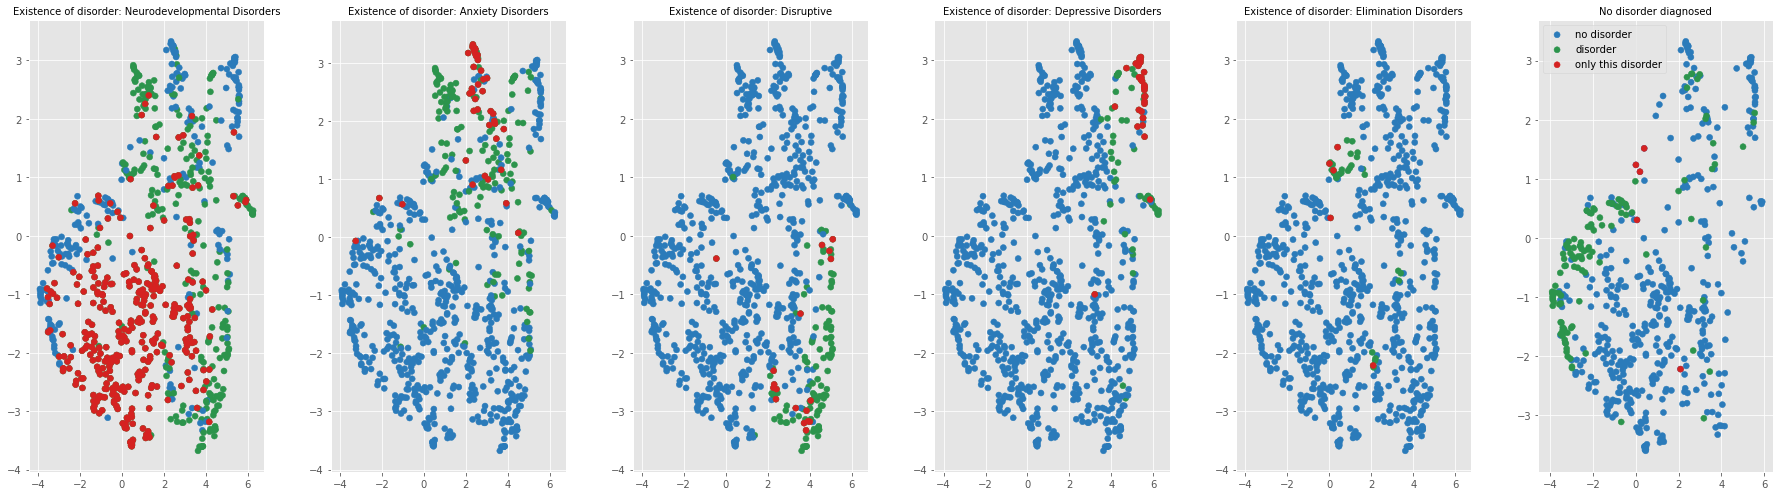

In [37]:
def plot_categories(embedding, classes):
    fig, ax = plt.subplots(nrows=1, ncols=len(most_common_disorders) + 1, figsize=(25, 7))

    def have_only_disorder(classes, i):
        res = set(list(range(classes.shape[0])))

        for k in range(classes.shape[1]):
            if k == i:
                res = res & set(np.where(classes[:, k] == 1)[0])
            else:
                res = res & set(np.where(classes[:, k] == 0)[0])

        return np.array(list(res))

    blue = sns.color_palette("Blues")[-2]
    red = sns.color_palette("Reds")[-2]
    green = sns.color_palette("Greens")[-2]
    for i in range(len(most_common_disorders)):
        ax[i].scatter(embedding[:, 0], embedding[:, 1], c=[green if x == 1 else blue for x in classes[:, i]])
        only_disorder = have_only_disorder(classes, i)
        ax[i].scatter(embedding[only_disorder, 0], embedding[only_disorder, 1], c=[red for _ in range(len(only_disorder))])
        # ax[i].set_gca().set_aspect('equal', 'datalim')
        ax[i].set_title('Existence of disorder: ' + most_common_disorders[i], fontsize=10);

    indx = np.where(np.sum(classes, axis=1) == 1)[0]
    ax[-1].scatter(embedding[indx, 0], embedding[indx, 1], c=[blue for _ in range(len(indx))], label='no disorder')
    indx = np.where(np.sum(classes, axis=1) == 0)[0]
    ax[-1].scatter(embedding[indx, 0], embedding[indx, 1], c=[green for _ in range(len(indx))], label='disorder')
    # dummy to get no indices
    indx = np.where(np.sum(classes, axis=1) == len(most_common_disorders) + 1)[0]
    ax[-1].scatter(embedding[only_disorder, 0], embedding[only_disorder, 1], c=[red for _ in range(len(only_disorder))], label='only this disorder')
    ax[-1].set_title('No disorder diagnosed', fontsize=10);

    ax[-1].legend()

    plt.tight_layout()
    plt.show()

plot_categories(embedding, train_classes)

In [38]:
from matplotlib import animation
from matplotlib import rc
from IPython.core.display import HTML
rc('animation', html='jshtml')

fig = plt.figure(figsize=(15, 8))
ax = plt.axes(xlim=(np.min(embedding[:, 0]) * 1.1, np.max(embedding[:, 0]) * 1.1), 
              ylim=(np.min(embedding[:, 1]) * 1.1, np.max(embedding[:, 1]) * 1.1))
ax.set_xticks([])
ax.set_yticks([])

scatter = ax.scatter(embedding[:, 0], embedding[:, 1])
title = ax.text(0.5,1.05,"Original data", size=plt.rcParams["axes.titlesize"], 
                ha="center", transform=ax.transAxes, )


blue = sns.color_palette("Blues")[-2]
green = sns.color_palette("Greens")[-2]

def update(frame_number):
    
    disorder_index = frame_number

    if disorder_index == len(most_common_disorders):
        no_disease = np.zeros(embedding.shape[0])
        no_disease[np.where(np.sum(train_classes, axis=1) == 0)[0]] = 1
        scatter.set_sizes([60 if x == 1 else 20 for x in no_disease])
        scatter.set_color([green if x == 1 else blue for x in no_disease])
        title.set_text('No disorder')
    else:
        scatter.set_sizes([60 if x == 1 else 20 for x in train_classes[:, disorder_index]])
        scatter.set_color([green if x == 1 else blue for x in train_classes[:, disorder_index]])
        title.set_text('Disorder: {}'.format(most_common_disorders[disorder_index]))
    return scatter, 

anim = animation.FuncAnimation(fig, update, interval=2000, frames=list(range(len(most_common_disorders) + 1)))
plt.close(fig)
HTML(anim.to_html5_video())

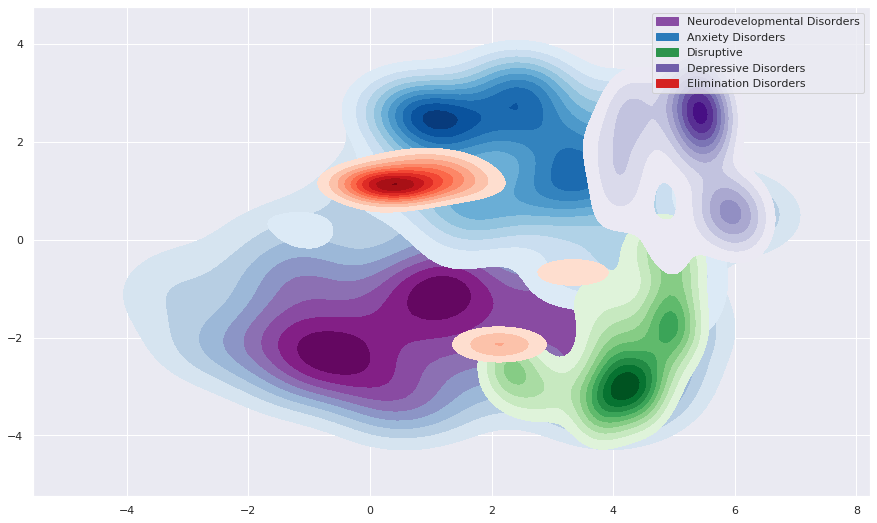

In [39]:
sns.set(style="darkgrid")
iris = sns.load_dataset("iris")

# Set up the figure
f, ax = plt.subplots(figsize=(15, 9))

cmaps = ["BuPu", "Blues", "Greens", "Purples", "Reds"]
for i in range(len(most_common_disorders)):
    indx = np.where(train_classes[:, i] == 1)[0]
    color = sns.color_palette(cmaps[i])[-2]
    sns.kdeplot(embedding[indx, 0], embedding[indx, 1], cmap=cmaps[i], shade=True, shade_lowest=False, label=most_common_disorders[i], color=color)

ax.legend()

#### Disorder by position

Number of instances per disorder
[605 201 125  90  35]


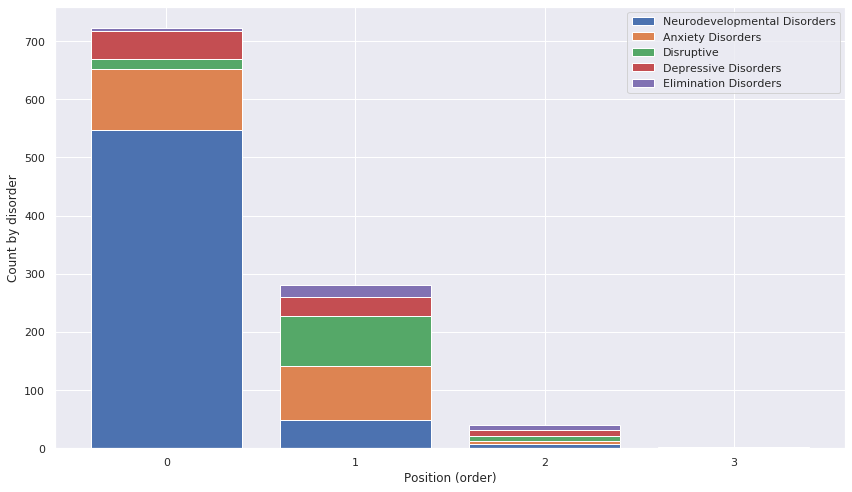

In [40]:
# all possible predictions orders
max_posiitions = max_len_order

# plot most likely disorder by position
count_disorders = np.zeros((max_posiitions, len(most_common_disorders)))
for i in range(1, max_posiitions + 1):
    for dis in range(len(most_common_disorders)):
        count_disorders[i - 1, dis] = len(np.where(train_orders[:, i] == dis)[0])

print('Number of instances per disorder')
print(np.sum(train_classes, axis=0))

positions = list(range(max_posiitions))

plt.figure(figsize=(12,7))

# stack bars
plt.bar(positions, count_disorders[:, 0], label=most_common_disorders[0])
prev = count_disorders[:, 0]

for i in range(1, len(most_common_disorders)):
    b = plt.bar(positions, count_disorders[:, i], bottom=prev, label=most_common_disorders[i])
    prev = np.cumsum(count_disorders, axis=1)[:, i]

plt.xlabel(list(range(1, max_posiitions + 1)))
plt.xticks(list(range(0, max_posiitions)))
plt.xlabel('Position (order)')
plt.ylabel('Count by disorder')
plt.legend()
plt.tight_layout()
plt.show()

### Better visualization of the latent space for all combinations of labels (define better colors for these)

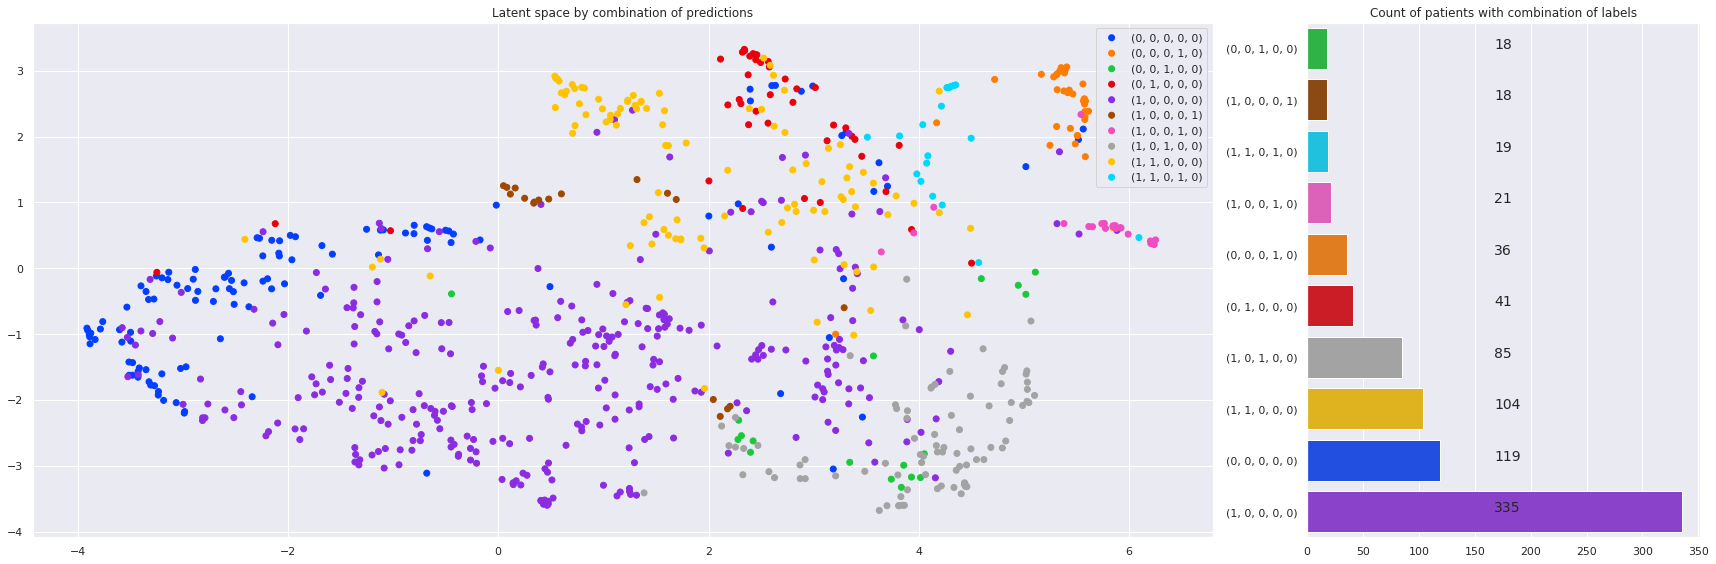

In [41]:
# TODO make this plot more informative!

# all possible combinations of classes
def combinations(classes):
    combos = list(set([tuple(x) for x in classes]))
    combos = sorted(combos, key=lambda tup: (tuple([tup[x] for x in range(len(combos[0]))])))
    indices = np.zeros((classes.shape[0], len(combos)))

    for i in range(len(combos)):
        indices[:, i] = [combos[i] == tuple(x) for x in classes]

    return [str(x) for x in combos], indices

combos, indices = combinations(train_classes)
per_category_counts = np.sum(indices, axis=0)

# keep only combination of labels with at least this many patients
thres = 10
ind = np.where(per_category_counts > thres)[0]
combos = np.array(combos)[ind]
indices = indices[:, ind]
# recompute per category counts

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(24, 8), gridspec_kw={'width_ratios': [3, 1]})

for i in range(len(combos)):
    indx = np.where(indices[:, i] == 1)[0]
    ax[0].scatter(embedding[indx, 0], embedding[indx, 1], 
                c=[sns.color_palette("bright", len(combos))[i] for _ in range(len(indx))], label=combos[i])

ax[0].legend()
ax[0].set_title('Latent space by combination of predictions')

args = np.argsort(per_category_counts[ind])
sorted_values = np.sort(per_category_counts[ind])
ax[1] = sns.barplot(x=sorted_values, y=np.array(combos)[args], 
                    palette=np.array(sns.color_palette("bright", len(combos)))[args])

mean_val = np.max(sorted_values) / 2
for i in range(len(ind)):
    ax[1].text(mean_val, i, int(sorted_values[i]), fontsize=14)

ax[1].set_title('Count of patients with combination of labels')

plt.tight_layout()
plt.show()

## Order of diagnoses from the latent space of the autoencoder! (deprecated. Use next case that sequence are tarined along with reconstruction error)

In [0]:
train_latent_space = model.get_latent_space(train)
test_latent_space = model.get_latent_space(test)

INFO:tensorflow:Restoring parameters from ./autoencoder_predict/model-1800
INFO:tensorflow:Restoring parameters from ./autoencoder_predict/model-1800


In [0]:
from disorder_generator import DisorderGenerator

hidden_size = 15
embed_size = 5
rnn_size = 12
max_generator_size = max_len_order + 2 # plus two for the bod and oed token

# three extra tokens for padding and bod (beggining of diagnosis) and eod (end of diagnosis)
vocab_size = len(most_common_disorders) + 3

disorder_generator = DisorderGenerator(hidden_size, embed_size, rnn_size, vocab_size, max_generator_size)

In [0]:
disorder_generator.fit(train_latent_space, train_orders, test_latent_space, test_orders, n_epochs=400, print_every_epoch=20)

In [0]:
sequences = disorder_generator.predict(test_latent_space)

From the predictions disregarding the order we can also achieve the multi-label predictions. In this case the f1-scores are as following:

In [0]:
def get_predictions_from_sequences(sequences):
    predictions = np.zeros((sequences.shape[0], len(most_common_disorders)), dtype=np.int32)
    for i, seq in enumerate(sequences.astype(int)):
        for s in seq:
            if s == eod_token:
                break
            predictions[i][s] = 1
    return predictions

In [0]:
predictions = get_predictions_from_sequences(sequences)

In [0]:
# remember the f1-scores of the autoencode_predict whose loss also contained a predictions loss were
# test f1_scores: 0.626 0.716 0.738 0.731 0.485 
f1_per_class(test_classes, predictions)

## Only sequences and reconstruction error

In [0]:
from autoencode_seq import AutoencodeSeq, get_predictions_from_sequences

beta=.01
activation=tf.nn.relu
layers=[100, 50] #[50, 25]
dropout=0.1
regularization=0 # 1e-4
masking=0.1

embed_size = 15
rnn_size = 64
max_generator_size = max_len_order + 2 # plus two for the bod and oed token
# three extra tokens for padding and bod (beggining of diagnosis) and eod (end of diagnosis)
vocab_size = len(most_common_disorders) + 3

model = AutoencodeSeq(train.shape[1], len(most_common_disorders), vocab_size, rnn_size, max_generator_size, 
                             embed_size, bod_token, eod_token, pad_token, beta=beta, activation=activation,
                             layers=layers, dropout=dropout, regularization=regularization, masking=masking)

In [43]:
learning_rate = 0.001
batch_size = 64
decay_steps = train.shape[0] // batch_size * 20

model.fit(train, train_mask, train_orders, test_data=test, test_data_mask=test_mask, 
          test_data_orders=test_orders, n_epochs=1000, print_every_epochs=50, 
          learning_rate=learning_rate, batch_size=batch_size, decay_steps=decay_steps)


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
At epoch    0 rec_loss:   0.1095 seq_loss   0.2144 seq correct tokens train 0.2785 and test 0.2786
	train f1_scores: 0.543 0.432 0.464 0.472 0.489 test f1_scores: 0.581 0.420 0.466 0.463 0.485 
At epoch   50 rec_loss:   0.0151 seq_loss   0.1058 seq correct tokens train 0.5388 and test 0.4679
	train f1_scores: 0.780 0.622 0.620 0.687 0.489 test f1_scores: 0.703 0.570 0.624 0.676 0.485 
At epoch  100 rec_loss:   0.0150 seq_loss   0.1009 seq correct tokens train 0.6010 and test 0.5214
	train f1_scores: 0.790 0.562 0.732 0.756 0.489 test f1_scores: 0.767 0.562 0.639 0.739 0.485 
At epoch  150 rec_loss:   0.0157 seq_loss   0.0912 seq correct tokens train 0.5694 and test 0.5000
	train f1_scores: 0.840 0.610 0.564 0.751 0.489 test f1_scores: 0.761 0.562 0.537 0.709 0.485 
At epoch  200 rec_loss:   0.0160 seq_loss   0.0859 seq correct tokens train 0.6287 and test 0.4857
	train f1_scores: 0.863 0.738 0.740 0.722 0

In [44]:
# sequences predictions
sequences = model.predict_sequences(test)
predictions_from_sequences = get_predictions_from_sequences(sequences, len(most_common_disorders))

# precision recall 
print(multi_label_accuracy(test_classes, predictions_from_sequences))
print(precision_recall(test_classes, predictions_from_sequences))
print(f1_per_class(test_classes, predictions_from_sequences))

INFO:tensorflow:Restoring parameters from ./autoencoder_seq/model-950
0.8578199052132701
(0.7937219730941704, 0.6298932384341637)
[0.7182910547396528, 0.7033486707566462, 0.6000702000702001, 0.7208994708994709, 0.48536585365853663]


In [45]:
print(np.sum(test_classes, axis=0))
print(np.sum(predictions_from_sequences, axis=0))

[154  58  28  29  12]
[161  38   9  15   0]


#### Again all visualizations here are only based on the train dataset

In [46]:
seq_latent_space = model.get_latent_space(train)

INFO:tensorflow:Restoring parameters from ./autoencoder_seq/model-950


In [0]:
import umap

reducer = umap.UMAP()
embedding = reducer.fit_transform(seq_latent_space)

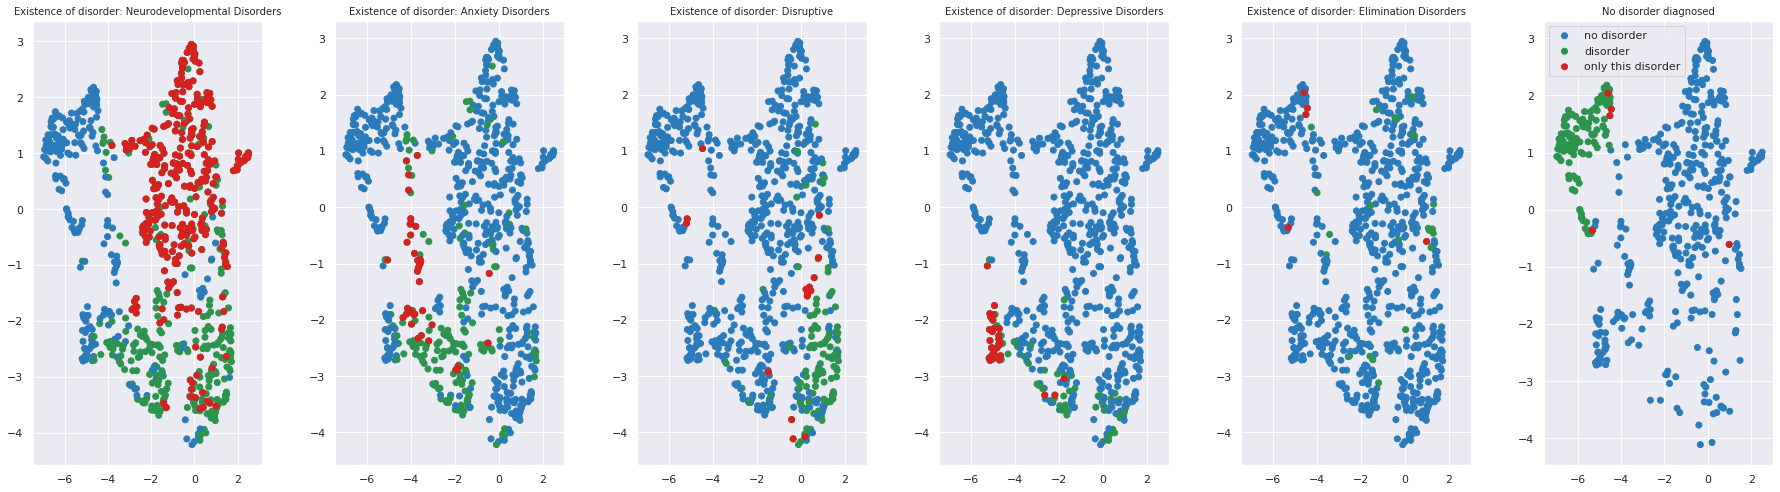

In [48]:
plot_categories(embedding, train_classes)

## Cross validation results

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

def mean_imputer(x, y):
    return np.where(np.isnan(x), np.ma.array(x, mask=np.isnan(x)).mean(axis=0), x),\
            np.where(np.isnan(y), np.ma.array(x, mask=np.isnan(x)).mean(axis=0), y)  

    
def run_cross_validation(df, classes, orders, fit_model_and_get_predictions, n_splits=5, drop_missing_threshold=0.5):
    kf = KFold(n_splits=n_splits, random_state=17, shuffle=True)
    kf.get_n_splits(df)

    final_predictions = np.zeros(classes.shape)
    final_orders = np.zeros(orders.shape)

    # split
    for train_index, test_index in kf.split(df):
        train, test = df.iloc[train_index], df.iloc[test_index]
        train_classes, test_classes = classes[train_index], classes[test_index]
        train_orders, test_orders = orders[train_index], orders[test_index]

        columns_mask = pd.isnull(train).sum() / train.shape[0] >= drop_missing_threshold

        print('Droping this many columns:', np.sum(columns_mask))

        dropped_columns = train.columns[columns_mask]

        train = train.drop(columns=dropped_columns)
        test = test.drop(columns=dropped_columns)

        train_mask = pd.isnull(train).values.astype(np.float32)
        test_mask = pd.isnull(test).values.astype(np.float32)

        # deal with numpy because of some weird SettingWithCopyWarning I cannot figure out
        # impute based on the mean values
        train, test = mean_imputer(train.values, test.values)

        scaler = MinMaxScaler()
        train = scaler.fit_transform(train)
        test = scaler.transform(test)

        final_predictions[test_index], final_orders[test_index] = fit_model_and_get_predictions(\
                    train, train_mask, train_classes, train_orders, test, test_mask, test_classes, test_orders)

    return final_predictions.astype(np.int16), final_orders.astype(np.int16)

def evaluate_predictions(classes, pred_classes, orders, pred_orders):
    if pred_classes is not None:
        print('Pred classes statistics')
        print('multi_label_accuracy', multi_label_accuracy(classes, pred_classes))
        print('precision_recall', precision_recall(classes, pred_classes))
        print('f1_per_class', f1_per_class(classes, pred_classes))
    if pred_orders is not None:
        print('Pred orders statistics')
        predictions_from_sequences = get_predictions_from_sequences(pred_orders, len(most_common_disorders))
        print('multi_label_accuracy', multi_label_accuracy(classes, predictions_from_sequences))
        print('precision_recall', precision_recall(classes, predictions_from_sequences))
        print('f1_per_class', f1_per_class(classes, predictions_from_sequences))

In [88]:
import tensorflow as tf
from autoencode_predict import AutoencodePredict, multi_label_accuracy, f1_per_class
    
def autoencode_predict_fit_predict(train, train_mask, train_classes, train_orders, 
                                   test, test_mask, test_classes, test_orders):
    alpha=0.2          # parameter showing the significance of the prediction loss
    activation=tf.nn.relu
    layers=[80, 20]
    prediction_layers=[50]
    dropout=0.1
    regularization=1e-5
    masking=0.1

    model = AutoencodePredict(train.shape[1], len(most_common_disorders), alpha=alpha, activation=activation, layers=layers,
                            prediction_layers=prediction_layers, dropout=dropout, regularization=regularization, 
                            masking=masking)

    learning_rate = 3e-3

    def smoothing_fun(a, beta=1):
        return [min(i, 1) for i in a] + beta * np.log([max(i - 1, 1) for i in a])

    pos_weights = smoothing_fun(1 / (np.sum(train_classes, axis=0) / train_classes.shape[0]))
    class_weights = [1, 1, 1, 1, 1]

    decay_steps = train.shape[0] // 64 * 20
    model.fit(train, train_mask, train_classes, test_data=test, test_data_mask=test_mask, test_data_labels=test_classes,
            n_epochs=801, print_every_epochs=200, pos_weights=pos_weights, class_weights=class_weights,
            decay_steps=decay_steps)
    
    # this model cannot predict the order
    return model.predict(test), np.zeros(test_orders.shape)

pred_classes, _ = run_cross_validation(combined_df, classes, orders, autoencode_predict_fit_predict)

Droping this many columns: 130
At epoch    0 rec_loss:   0.1029 reg_loss:   0.0252 pred_loss:   2.1455 train_acc: 0.8366 test_acc 0.8256
	train f1_scores: 0.418 0.432 0.460 0.472 0.489 test f1_scores: 0.422 0.420 0.464 0.463 0.485 
At epoch  200 rec_loss:   0.0145 reg_loss:   0.0149 pred_loss:   1.1129 train_acc: 0.9031 test_acc 0.8597
	train f1_scores: 0.779 0.798 0.843 0.875 0.869 test f1_scores: 0.723 0.781 0.742 0.780 0.480 
At epoch  400 rec_loss:   0.0149 reg_loss:   0.0175 pred_loss:   0.9722 train_acc: 0.9306 test_acc 0.8531
	train f1_scores: 0.813 0.847 0.908 0.923 0.951 test f1_scores: 0.729 0.762 0.747 0.747 0.476 
At epoch  600 rec_loss:   0.0148 reg_loss:   0.0192 pred_loss:   0.8176 train_acc: 0.9468 test_acc 0.8531
	train f1_scores: 0.845 0.903 0.926 0.936 0.985 test f1_scores: 0.751 0.762 0.720 0.714 0.480 
At epoch  800 rec_loss:   0.0154 reg_loss:   0.0202 pred_loss:   0.8193 train_acc: 0.9544 test_acc 0.8483
	train f1_scores: 0.866 0.913 0.943 0.941 0.979 test f1_sco

In [89]:
evaluate_predictions(classes, pred_classes, None, None)

Pred classes statistics
multi_label_accuracy 0.8305792972459639
precision_recall (0.6522929500342232, 0.712789827973074)
f1_per_class [0.7273715824357911, 0.6844806107907626, 0.6828234945559588, 0.6664835781640901, 0.48102513553474613]


alpha=0.2          # parameter showing the significance of the prediction loss
activation=tf.nn.relu
layers=[50, 25]
prediction_layers=[125, 50]
dropout=0.1
regularization=1e-5
masking=0.1

model = AutoencodePredict(train.shape[1], len(most_common_disorders), alpha=alpha, activation=activation, layers=layers,
                        prediction_layers=prediction_layers, dropout=dropout, regularization=regularization, 
                        masking=masking)

learning_rate = 3e-3
<br>
Pred classes statistics<br>
multi_label_accuracy 0.8284900284900285<br>
precision_recall (0.6420157068062827, 0.7337322363500374)<br>
f1_per_class [0.722889481071239, 0.6816317449813745, 0.7031403812824957, 0.6784007871029896, 0.49083582776882345]


## Autoencoder + classification + order of diagnoses (not working for the time being)

In [0]:
from autoencoder_sequence_predict import AutoencodeSeqPredict

alpha=.03
beta=.07
activation=tf.nn.relu
layers=[50, 25]
prediction_layers=[100, 25]
dropout=0.1
regularization=0.#1e-5
masking=0.15

hidden_size = 15
embed_size = 32
rnn_size = 64
max_generator_size = max_len_order + 2 # plus two for the bod and oed token
# three extra tokens for padding and bod (beggining of diagnosis) and eod (end of diagnosis)
vocab_size = len(most_common_disorders) + 3

model = AutoencodeSeqPredict(train.shape[1], len(most_common_disorders), vocab_size, rnn_size, max_generator_size, 
                             embed_size, bod_token, eod_token, pad_token, alpha=alpha, beta=beta, activation=activation,
                             layers=layers, dropout=dropout, regularization=regularization, masking=masking,
                             prediction_layers=prediction_layers)

In [0]:
# set larger weight for instances of disorders that are very infrequent
def smoothing_fun(a, beta=1):
    return [min(i, 1) for i in a] + beta * np.log([max(i - 1, 1) for i in a])

pos_weights = smoothing_fun(1 / (np.sum(train_classes, axis=0) / train_classes.shape[0]))
class_weights = [1, 1, 1, 1, 1]
learning_rate = 0.03
batch_size = 64
decay_steps = train.shape[0] // batch_size * 100

model.fit(train, train_mask, train_classes, train_orders, test_data=test, test_data_mask=test_mask, 
          test_data_labels=test_classes, test_data_orders=test_orders, 
          pos_weights=pos_weights, class_weights=class_weights, n_epochs=500, print_every_epochs=10, 
          learning_rate=learning_rate, batch_size=batch_size, decay_steps=decay_steps)

In [0]:
# predictions per class
preds = model.predict(test)

print('multi_label_accuracy', multi_label_accuracy(test_classes, preds))

# total recall

indices = np.where(test_classes == 1)
total = len(indices[0])
found = 0
for i, j in zip(indices[0], indices[1]):
    found += preds[i][j]

print('Total recall:', found / total)
print('Total precision:', found / np.sum(preds))

print(test.shape)
print(np.sum(test_classes, axis=0))
print(np.sum(preds, axis=0))

In [0]:
# sequences predictions
sequences = model.predict_sequences(test)

def get_predictions_from_sequences(sequences):
    predictions = np.zeros((sequences.shape[0], len(most_common_disorders)), dtype=np.int32)
    for i, seq in enumerate(sequences.astype(int)):
        for s in seq:
            if s == eod_token:
                break
            predictions[i][s] = 1
    return predictions

predictions = get_predictions_from_sequences(sequences)

f1_per_class(test_classes, predictions)

INFO:tensorflow:Restoring parameters from ./autoencoder_predict/model-6100


[0.7294871794871794,
 0.6027281460134486,
 0.5266025641025642,
 0.7208994708994709,
 0.48536585365853663]

In [0]:
for a, b in zip(test_orders[:10], sequences[:10]):
    print(a, b)

[6 7 5 5 5 5] [7. 7. 7. 7. 7.]
[6 0 2 7 5 5] [0. 7. 7. 7. 7.]
[6 7 5 5 5 5] [0. 7. 7. 7. 7.]
[6 0 7 5 5 5] [0. 7. 7. 7. 7.]
[6 3 2 7 5 5] [0. 7. 7. 7. 7.]
[6 2 7 5 5 5] [0. 7. 7. 7. 7.]
[6 7 5 5 5 5] [7. 7. 7. 7. 7.]
[6 3 0 7 5 5] [0. 7. 7. 1. 7.]
[6 3 1 0 4 7] [0. 7. 7. 7. 7.]
[6 7 5 5 5 5] [7. 7. 7. 7. 7.]
